In [1]:
import cv2
import torch
from matplotlib import pyplot as plt

from wings.config import MODELS_DIR
from wings.modeling.litnet import LitNet
from wings.modeling.loss import DiceLoss
from wings.utils import load_image
from wings.visualizing.image_preprocess import unet_fit_rectangle_preprocess, final_coords
from wings.visualizing.visualize import visualize_coords

countries = ['AT', 'GR', 'HR', 'HU', 'MD', 'PL', 'RO', 'SI']


2025-09-29 22:13:12.026 | INFO     | wings.config:<module>:40 - PROJ_ROOT path is: /home/mkrajew/bees
2025-09-29 22:13:12.127 | INFO     | wings.config:<module>:62 - torch.cuda.get_device_name()='NVIDIA RTX A3000 12GB Laptop GPU'


In [2]:
checkpoint_path = MODELS_DIR / 'unet-rectangle-epoch=08-val_loss=0.14-unet-training-rectangle_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()


Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


LitNet(
  (model): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): BatchNor

In [3]:
filepath = "/home/mkrajew/bees/data/raw/PL-wing-images/PL-0001-000420-R.dw.png"

image_tensor, x_size, y_size = load_image(filepath, unet_fit_rectangle_preprocess)
# print(image_tensor.shape)
img = cv2.imread(filepath, cv2.IMREAD_COLOR)

In [4]:
output = model(image_tensor.cuda().unsqueeze(0))
mask = torch.round(output).squeeze().detach().cpu().numpy()


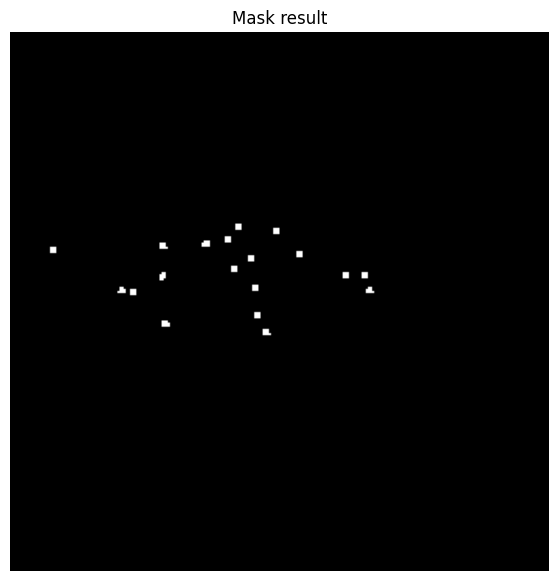

In [5]:
# Show the result
plt.figure(figsize=(7, 7))
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title("Mask result")
plt.show()

Coordinates:
X	Y
457	106
276	121
442	136
219	178
643	181
197	181
439	185
635	208
601	208
272	208
401	219
431	238
518	246
76	253
272	261
348	265
389	272
476	287
408	295


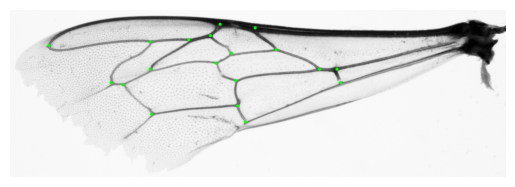

In [6]:
try:
    mask_coords = final_coords(mask, x_size, y_size)

    print("Coordinates:")
    print("X\tY")
    for cords in mask_coords:
        print(f"{cords[0]:.0f}\t{cords[1]:.0f}")

    flat_coords = [coord for pair in mask_coords for coord in pair]  # Flatten list of tuples
    target_tensor = torch.tensor(flat_coords, dtype=torch.float32)

    # print(flat_coords)

    # Visualize
    visualize_coords(img, target_tensor, spot_size=3)

except Exception as e:
    plt.imshow(mask)
    plt.axis('off')
    plt.show()
    print(e)

# TODO: czy wspolrzedne musza byc zwracane w odpowiedniej kolejnosci???